In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from pathlib import Path

dataroot = Path("./dataset_npy")

In [3]:
markup = pd.read_csv("./dataset/labels.csv")

In [4]:
markup

,image,level
0,19840_left,2
1,32380_right,0
2,32242_right,2
3,32610_right,0
4,27041_right,0
...,...,...
7995,22729_left,0
7996,24524_left,2
7997,32598_left,2
7998,19350_right,2


In [5]:
markup["level"].value_counts()

level
0    5912
2    1196
1     530
3     205
4     157
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_images, test_images = train_test_split(markup,
                                            test_size=0.2,
                                            stratify=markup["level"],
                                            random_state=42)

In [8]:
val_images, test_images = train_test_split(test_images,
                                           test_size=0.5,
                                           stratify=test_images["level"],
                                           random_state=42)

In [9]:
train_images["level"].value_counts(), val_images["level"].value_counts(), test_images["level"].value_counts()

(level
 0    4730
 2     957
 1     424
 3     164
 4     125
 Name: count, dtype: int64,
 level
 0    591
 2    119
 1     53
 3     21
 4     16
 Name: count, dtype: int64,
 level
 0    591
 2    120
 1     53
 3     20
 4     16
 Name: count, dtype: int64)

In [10]:
n_samples = train_images["level"].value_counts()

In [11]:
len(train_images)

6400

In [12]:
for i in range(1, 5):
    tmp_df = train_images[train_images["level"] == i]
    for j in range(n_samples[0]//n_samples[i]):
        train_images = pd.concat([train_images, tmp_df], ignore_index=True)

In [13]:
train_images["level"].value_counts()

level
1    5088
2    4785
3    4756
4    4750
0    4730
Name: count, dtype: int64

In [14]:
train_images

,image,level
0,23702_left,2
1,42011_left,0
2,18021_left,0
3,24879_right,0
4,33316_left,0
...,...,...
24104,43141_right,4
24105,38856_right,4
24106,37951_right,4
24107,33906_left,4


In [15]:
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [22]:
def load_img(path2img):
    img = cv2.imread(str(path2img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

In [ ]:
n_samples = 5
fig, ax = plt.subplots(5, 5, figsize=(10 * n_samples, 50))
for i in range(5):
    samples = train_images[train_images["level"] == i]
    samples = np.random.choice(samples["image"], size=n_samples)
    for j, name in enumerate(samples):
        # print(dataroot / name / ".jpeg")
        tmp_img = load_img(dataroot / (name + ".jpeg"))
        ax[i][j].imshow(tmp_img)
        ax[i][j].set_title(name)
        ax[i][j].axis("off")

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

In [18]:
def np2torch(img):
    '''
    img --- np.ndarray HxWxC
    '''
    img = img.transpose(2, 0, 1)
    img = torch.tensor(img)
    return img
def torch2np(img):
    '''
    img --- torch.tensor CxHxW
    '''
    img = img.numpy()
    img = img.transpose(1, 2, 0)
    return img

In [77]:
def crop_center(img,cropx,cropy):
    x, y, _ = img.shape
    x_pad = 0
    y_pad = 0
    if (x < 1024):
        x_pad = (1024 - x) // 2 + (1024 - x) % 2
    if (y < 1024):
        y_pad = (1024 - y) // 2 + (1024 - y) % 2
        
    tmp_img = np.pad(img, ((x_pad, x_pad), (y_pad, y_pad), (0, 0)), mode='constant')
    x, y, _ = tmp_img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return tmp_img[startx:startx+cropx,starty:starty+cropy]

412 412


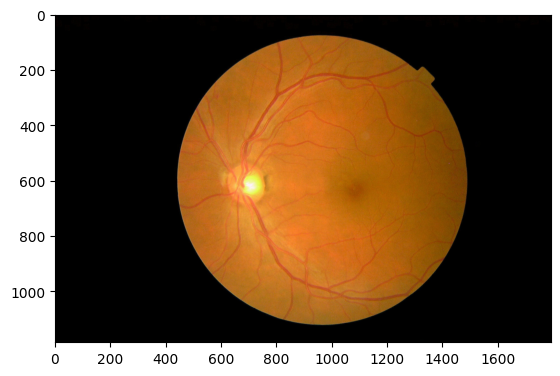

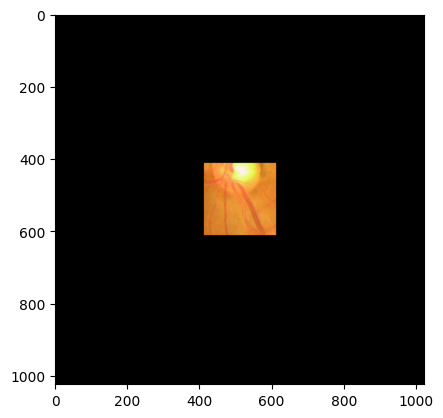

In [76]:
plt.imshow(tmp_img)
plt.figure()
plt.imshow(crop_center(tmp_img[600:800, 600:800], 1024, 1024))

In [108]:
imgs = np.zeros(shape=(8000, 1024, 1024, 3), dtype=np.uint8)

In [109]:
imgs_index = {}
for i, img_name in enumerate(tqdm(markup["image"])):
    imgs_index[img_name] =  i
    tmp_img = load_img(Path("./dataset/train") / (img_name + ".jpeg"))
    tmp_img = crop_center(tmp_img, 1024, 1024)
    imgs[i] = tmp_img

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [17:03<00:00,  7.82it/s]


In [127]:
class BioDataset(Dataset):
    def __init__(self,
                 markup,
                 imgs_index,
                 imgs,
                 transform):
        self.markup = markup.values
        self.imgs_index = imgs_index
        self.imgs = imgs
        self.transform = transform
    def __getitem__(self, index):
        img_name, label = self.markup[index]
        img = self.imgs[self.imgs_index[img_name]]
        img = (img.astype(np.float32)) / 255
        img = self.transform(img)
        # if torch.rand(1) >= 0.5:
        #    img = img[:, :, ::-1]
        #img = (img - img.min()) / (img.max() - img.min())
        return img, label
    def __len__(self):
        return len(self.markup)

In [112]:
transform =  transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(size=(512, 512))])

In [163]:
from torchmetrics.classification import MulticlassPrecision

In [191]:
def train(model,
          dataloader_train,
          dataloader_val,
          optimizer,
          scheduler,
          n_epochs,
          calc_loss,
          device):
    losses = {
        "train": [],
        "val": []
    }
    prec = {
        "train": [],
        "val": []
    }
    mcp = MulticlassPrecision(num_classes=5, average=None).to(device)
    for epoch in range(n_epochs):
        model.train()
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f"./weights/{epoch}.pth")
        epoch_loss = []
        train_precisions = []
        for img, labels in tqdm(dataloader_train):
            optimizer.zero_grad()
            img = img.to(device)
            labels = labels.to(device)
            pred = model(img)

            loss = calc_loss(pred, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            precision = mcp(pred, labels)
            train_precisions.append(precision.cpu().numpy())
            epoch_loss.append(loss.item())
        prec["train"].append(np.mean(train_precisions, axis=0))
        losses["train"].append(np.mean(epoch_loss))
        model.eval()
        epoch_loss = []
        val_precisions = []
        for img, labels in tqdm(dataloader_val):
            img = img.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                pred = model(img)
            
            loss = calc_loss(pred, labels)
            val_precisions.append(mcp(pred, labels).cpu().numpy())
            epoch_loss.append(loss.item())
        losses["val"].append(np.mean(epoch_loss))
        prec["val"].append(np.mean(val_precisions, axis=0))
        print(f"{epoch + 1}, train_loss: {losses['train'][-1]}, val_loss: {losses['val'][-1]}")
        print(f"train_prec={prec['train'][-1]}, val_prec={prec['val'][-1]}")
    return losses, prec

In [165]:
batch_size = 64
dataset_train = BioDataset(markup=train_images,
                           transform=transform,
                           imgs=imgs,
                           imgs_index=imgs_index)
dataset_val = BioDataset(markup=val_images,
                         transform=transform,
                         imgs=imgs,
                         imgs_index=imgs_index)
dataloader_train = DataLoader(dataset_train,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=2,
                             pin_memory=True)
dataloader_val = DataLoader(dataset_val,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            pin_memory=True)

In [117]:
len(dataset_val)

800

In [180]:
n_epochs = 50
lr = 3e-4

In [192]:
model = torchvision.models.mobilenet_v3_small(None)

In [193]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [194]:
classifier = nn.Sequential(
                nn.Linear(576, 1024, bias=True),
                nn.Hardswish(),
                nn.Dropout(p=0.2, inplace=True),
                nn.Linear(1024, 5, bias=True),
                nn.Softmax(dim=1))

In [195]:
model.classifier = classifier

In [196]:
opt = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=3e-4, max_lr=1e-3, mode='exp_range', step_size_up=5, gamma=0.85, cycle_momentum=False)

In [197]:
device = "cuda:1"

In [198]:
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
losses, prec = train(model,
              dataloader_train,
              dataloader_val,
              opt,
              scheduler,
              n_epochs,
              criterion,
              device)


  0%|                                                                                                          | 0/13 [00:00<?, ?it/s]

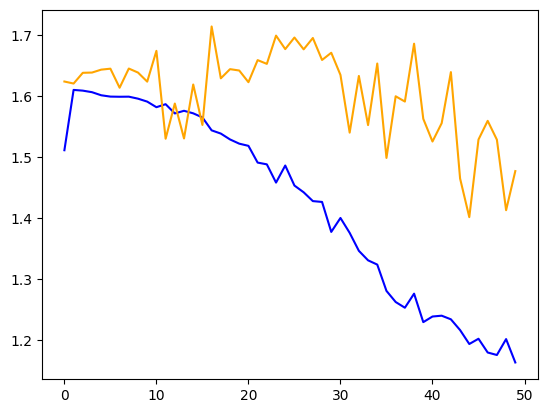

In [201]:
plt.plot(losses["train"], color="blue")
plt.plot(losses["val"], color="orange")

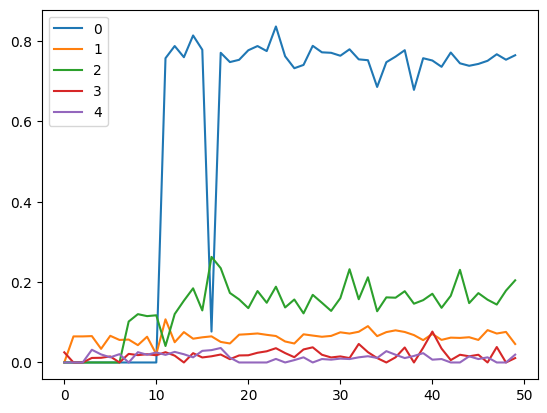

In [211]:
for i in range(5):
    plt.plot(np.array(prec["val"])[:, i], label=i)
plt.legend()